# Data import and visualisation
Data presented lower are exports from FreeStyle Libre reader (without physical activity from FitBit smart band). Data contain features
regarding blood glucose levels, injected insulin units of fast and slow acting insulin and information about carbohydrates consumed in grams.

Since 9.1., the information about carbohydrates, insulin and some additional features are recorded in mySugr app due to it being more convinient
than the reader interface. It also allows keeping track of glycemic index (estimation of how fast carbohydrates get into blood).

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Plotting style
sns.set_style("whitegrid")

In [3]:
from dataset import load_reader_dataset, load_mySugr_dataset, load_fitbit_dataset

In [4]:
df = load_reader_dataset()

# Convert from mmol/l to mg/dl
df["Glucose"] = df["Glucose"] * 18.016

### Loading data from mySugr app, containing insulin info as well as carbohydrates, glycemic index estimates and others

In [5]:
mysugr_df = load_mySugr_dataset()

Joining mySugr dataset with reader dataset

In [6]:
df = df.merge(mysugr_df, how='outer')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51591 entries, 0 to 51590
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Time                    51591 non-null  datetime64[ns]
 1   Record Type             49804 non-null  float64       
 2   Glucose                 38337 non-null  float64       
 3   Scan Glucose (mmol/L)   10405 non-null  float64       
 4   Rapid Insulin           1051 non-null   float64       
 5   Carbohydrates           1605 non-null   float64       
 6   Long Insulin            184 non-null    float64       
 7   Strip Glucose (mmol/L)  51 non-null     float64       
 8   Previous Time           9 non-null      object        
 9   Updated Time            9 non-null      object        
 10  Date                    1787 non-null   object        
 11  Tags                    5 non-null      object        
 12  Insulin (Meal)          280 non-null    float6

Filter relevant time-range and sort by time for chronological order

In [7]:
start_date = "2021/12/01 00:00"
mysugr_start_date = "2022/01/09 00:00"
end_date = "2022/04/08 00:00"

df = df[(df["Time"] <= end_date) & (df["Time"] >= start_date)]
df.sort_values(by='Time', inplace=True)

## Basic data characterization

In [101]:
df[["Glucose", "Rapid Insulin", "Carbohydrates", "Long Insulin"]].describe()

,Glucose,Rapid Insulin,Carbohydrates,Long Insulin
count,11970.000000,640.000000,1372.000000,126.000000
mean,137.692661,5.010937,16.013120,12.547619
std,51.064272,2.844131,13.266603,2.236451
min,50.444800,1.000000,2.000000,5.000000
25%,99.088000,2.000000,7.000000,11.000000
50%,131.516800,5.000000,11.000000,13.000000
75%,169.350400,8.000000,20.000000,15.000000
max,340.502400,10.000000,70.000000,15.000000


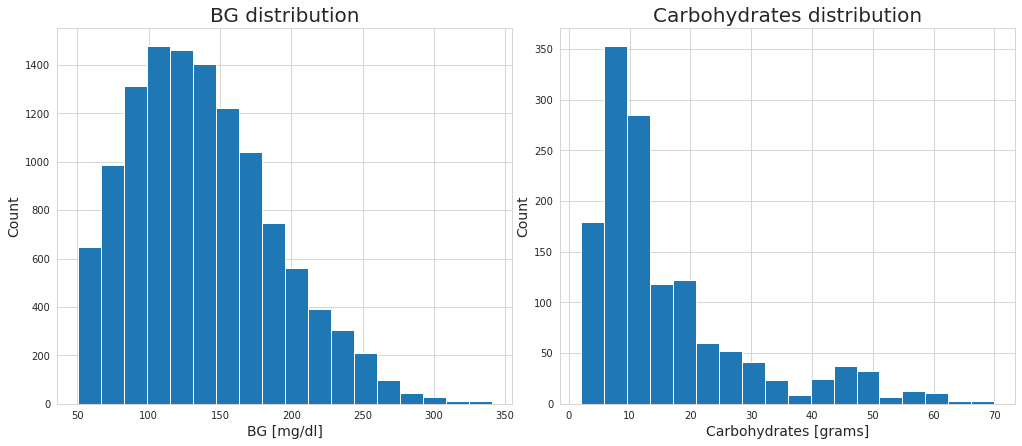

In [156]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(14,6))
label_size = 14
title_size = 20
ax1.hist(df["Glucose"], bins=18)
ax1.set_title('BG distribution', fontsize=title_size)
ax1.set_ylabel("Count", fontsize=label_size)
ax1.set_xlabel("BG [mg/dl]", fontsize=label_size)

plt.hist(df["Carbohydrates"], bins=18)
ax2.set_title('Carbohydrates distribution', fontsize=title_size)
ax2.set_ylabel("Count", fontsize=label_size)
ax2.set_xlabel("Carbohydrates [grams]", fontsize=label_size)
f.tight_layout(pad=0.01)
plt.savefig(fname="figures/bg_carbs_distribution.png");

### Glucose behavior in time in approximately weekly intervals
- red line **10** mmol/L represents the boundry of high glucose
- between orange and purple lines lies the ideal (healthy) range of glucose - **3.3 to 7.8** mmol/L
- under purple line, **3.3** mmol/L is the range of low glucose

In [133]:
def plot_boundries(low=3.3*18.016, medium=7.8*18.016, high=10*18.016):
    plt.axhline(y=low, color ='purple', linestyle='-')
    plt.axhline(y=medium, color='orange', linestyle='-')
    plt.axhline(y=high, color='r', linestyle='-')

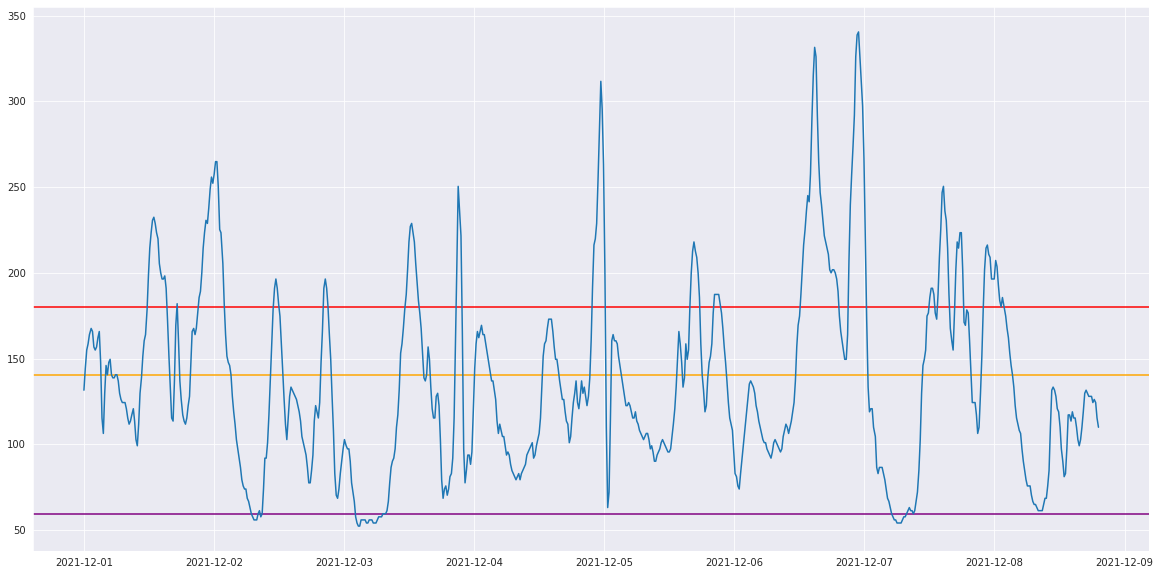

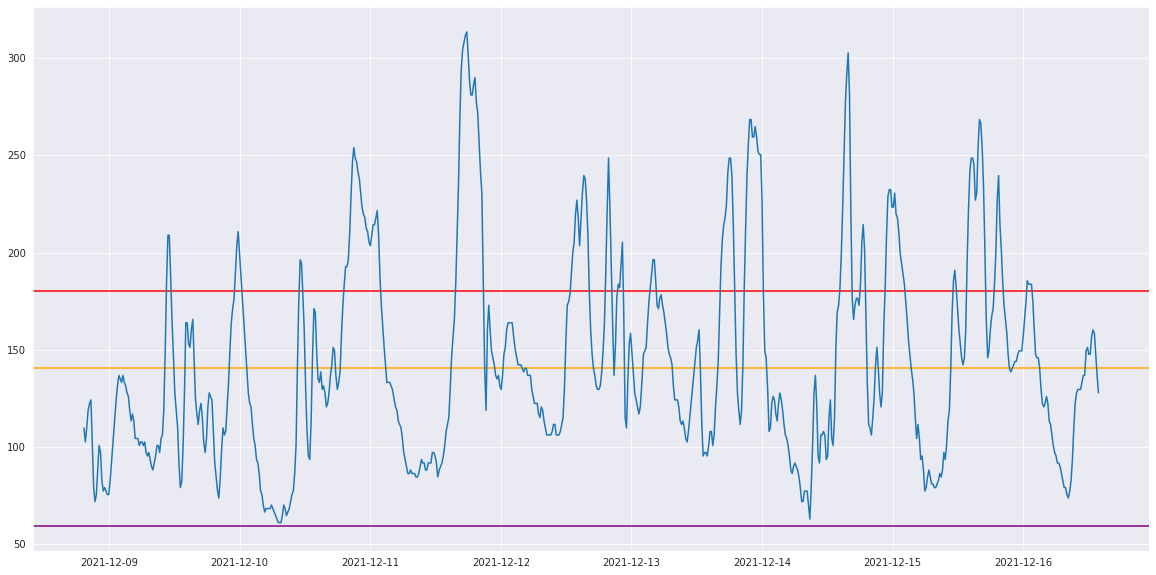

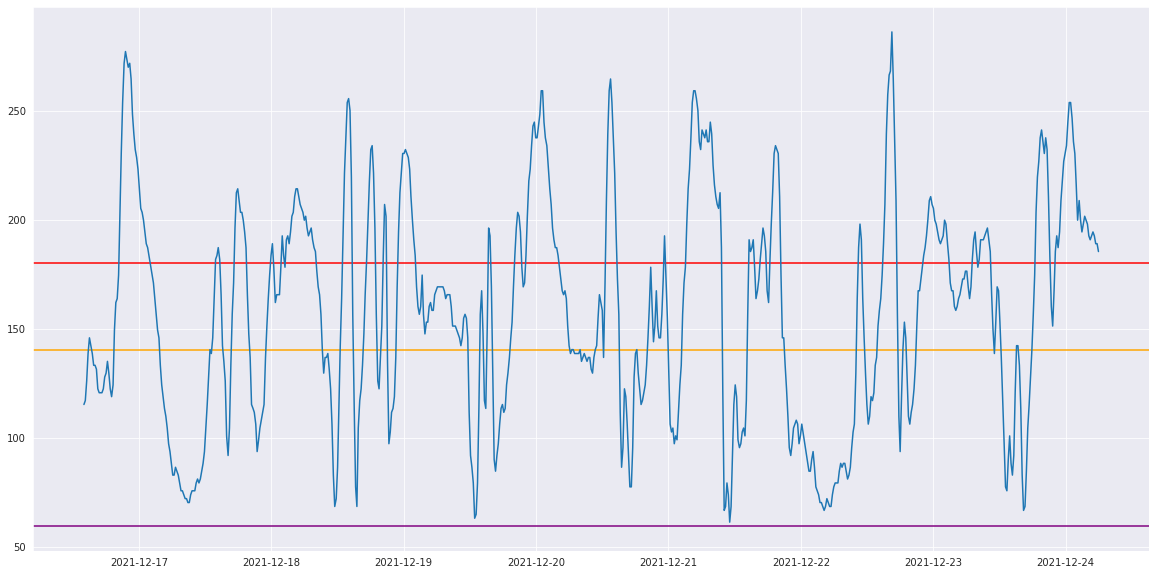

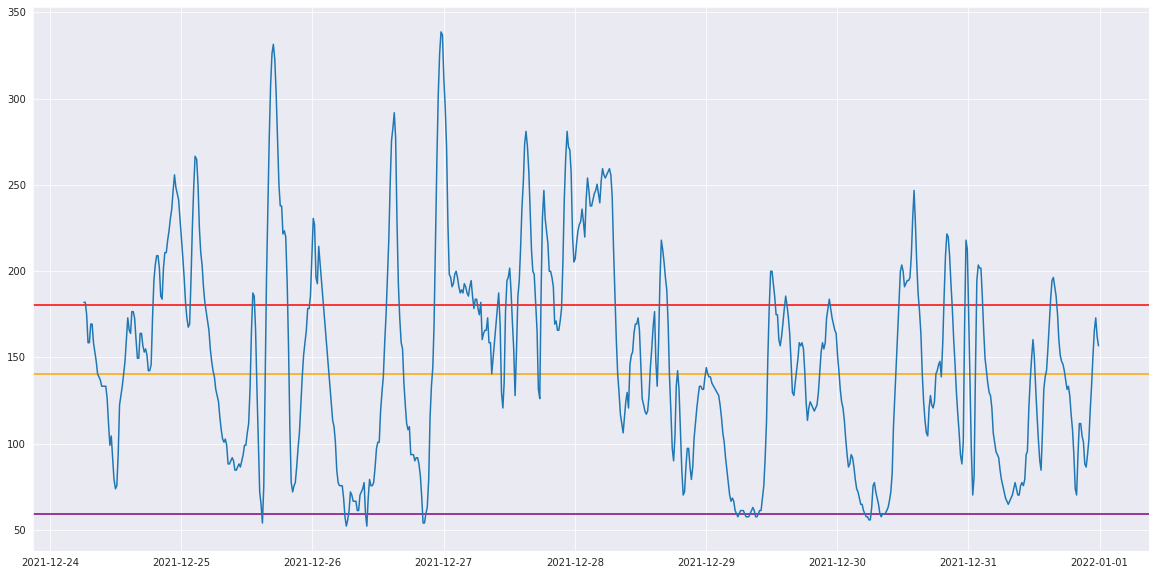

In [134]:
december_df = df[(df["Time"] <= "2022/01/01 00:00") & (df["Time"] >= "2021/12/01 00:00")]
duration = december_df["Time"].iloc[-1] - december_df["Time"].iloc[0]

# Divide to approximately weekly chunks of data
chunks = duration.days // 7
# We're dropping records for insulin and carbohydrates (we're only plotting glucose)
weekly_df = np.array_split(december_df.dropna(subset=["Glucose", "Time"]), chunks)

for chunk_df in weekly_df:
    plt.figure(figsize=(20, 10))
    plot_boundries()
    plt.plot(chunk_df["Time"], chunk_df["Glucose"])

    #plot_boundries()
    plt.show()

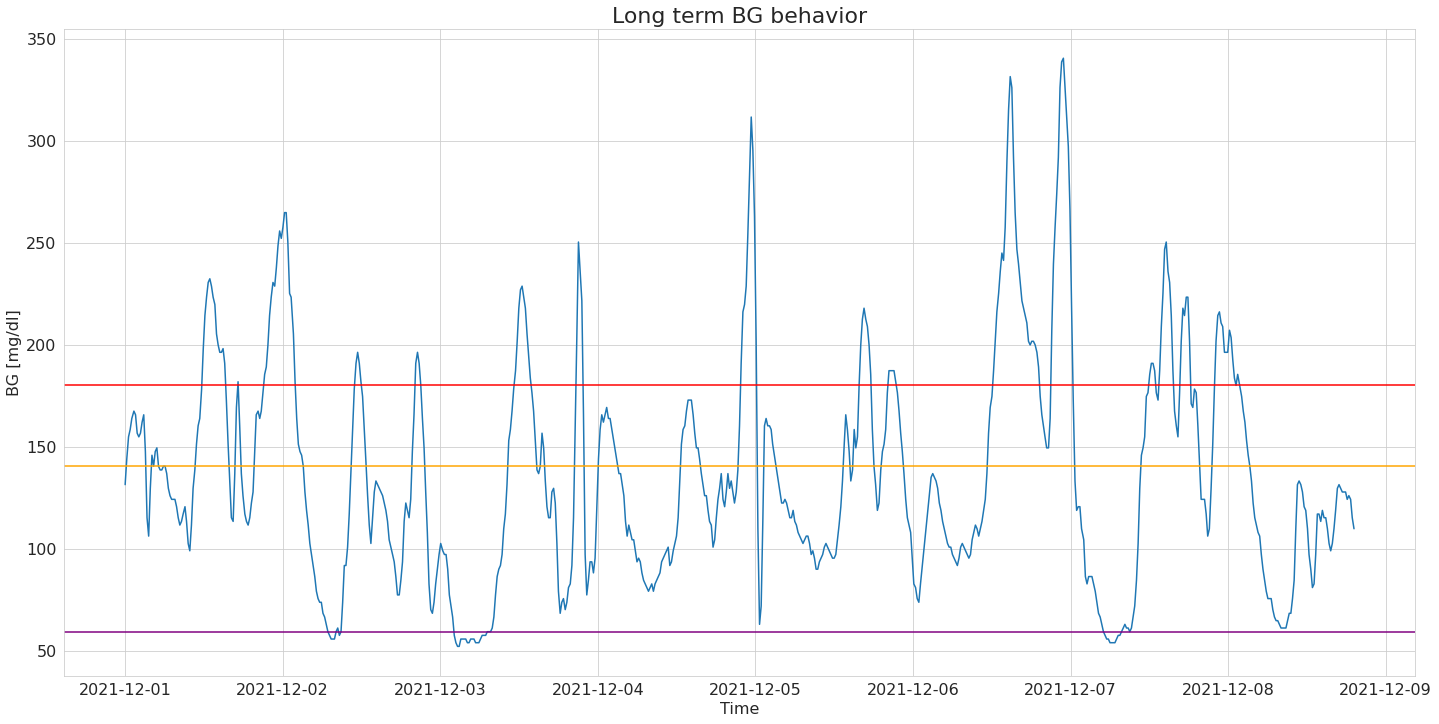

In [213]:
label_size, title_size = 16, 22

single_chunk = weekly_df[0]
plt.figure(figsize=(20, 10))
plt.plot(single_chunk["Time"], single_chunk["Glucose"])
plt.title("Long term BG behavior", fontsize=title_size)
plt.xlabel("Time", fontsize=label_size)
plt.ylabel("BG [mg/dl]", fontsize=label_size)
plt.xticks(fontsize=label_size)
plt.yticks(fontsize=label_size)
plot_boundries()
plt.tight_layout(pad=0.5)
plt.savefig(fname="figures/bg_long_term.png");

### Behavior of glucose in the individual days together with carbohydrates and insulin quantities scattered over the plot

In [214]:
def get_daily_charts(df_in: pd.DataFrame, start_day=2, duration_days=5, save=False):
    df = df_in.copy()

    label_size, tick_size, title_size = 16, 16, 22

    # Fix later (copy being done somewhere)
    pd.options.mode.chained_assignment = None
    duration = df["Time"].iloc[-1] - df["Time"].iloc[0]

    daily_df_list = np.array_split(df, duration.days)
    # For each day do a plot
    for day_df in daily_df_list[start_day:start_day + duration_days]:
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot()

        glucose_data = day_df.dropna(subset=["Glucose", "Time"])
        ax.plot(glucose_data["Time"], glucose_data["Glucose"])
        ax.set_ylabel("BG [mg/dl]", fontsize=label_size)
        ax.set_xlabel("Time", fontsize=label_size)

        plot_boundries()

        rapid_insulin = day_df.dropna(subset=["Rapid Insulin"])
        carbs = day_df.dropna(subset=["Carbohydrates"])

        # Normalize data to better plot to a standardized scale
        carbs_max = carbs["Carbohydrates"].abs().max()
        carbs["carbs_normalized"] = carbs.apply(lambda row: row["Carbohydrates"] / carbs_max, axis=1)
        ins_max = rapid_insulin["Rapid Insulin"].abs().max()
        rapid_insulin["rapid_insulin_normalized"] = rapid_insulin.apply(lambda row: row["Rapid Insulin"] / ins_max, axis=1)

        plt.xticks(fontsize=tick_size)
        plt.yticks(fontsize=tick_size)

        ax2 = ax.twinx()
        ax2.scatter(carbs["Time"], carbs["carbs_normalized"], color="red")
        # Set carbohydrates labels to the real (not-normalized) amount of grams consumed
        for idx, row in carbs.iterrows():
            ax2.text(row["Time"], row["carbs_normalized"]+0.02, row["Carbohydrates"], fontsize=14)

        # The same for insulin
        ax2.scatter(rapid_insulin["Time"], rapid_insulin["rapid_insulin_normalized"], color="purple")
        # Set carbohydrates labels to the real (not-normalized) amount of grams consumed
        for idx, row in rapid_insulin.iterrows():
            ax2.text(row["Time"], row["rapid_insulin_normalized"]+0.02, row["Rapid Insulin"], fontsize=14)

        plt.legend(["Carbohydrates [grams]", "Rapid Insulin [units]"], loc="upper right", fontsize=label_size)
        plt.title("BG behavior", fontsize=title_size)
        ax2.set_ylabel("Insulin and Carbohydrates normalized to (0, 1)", fontsize=label_size)

        if save:
            plt.tight_layout(pad=0.5)
            plt.savefig(fname="figures/bg_short_term_labeled.png")
        else:
            plt.show()

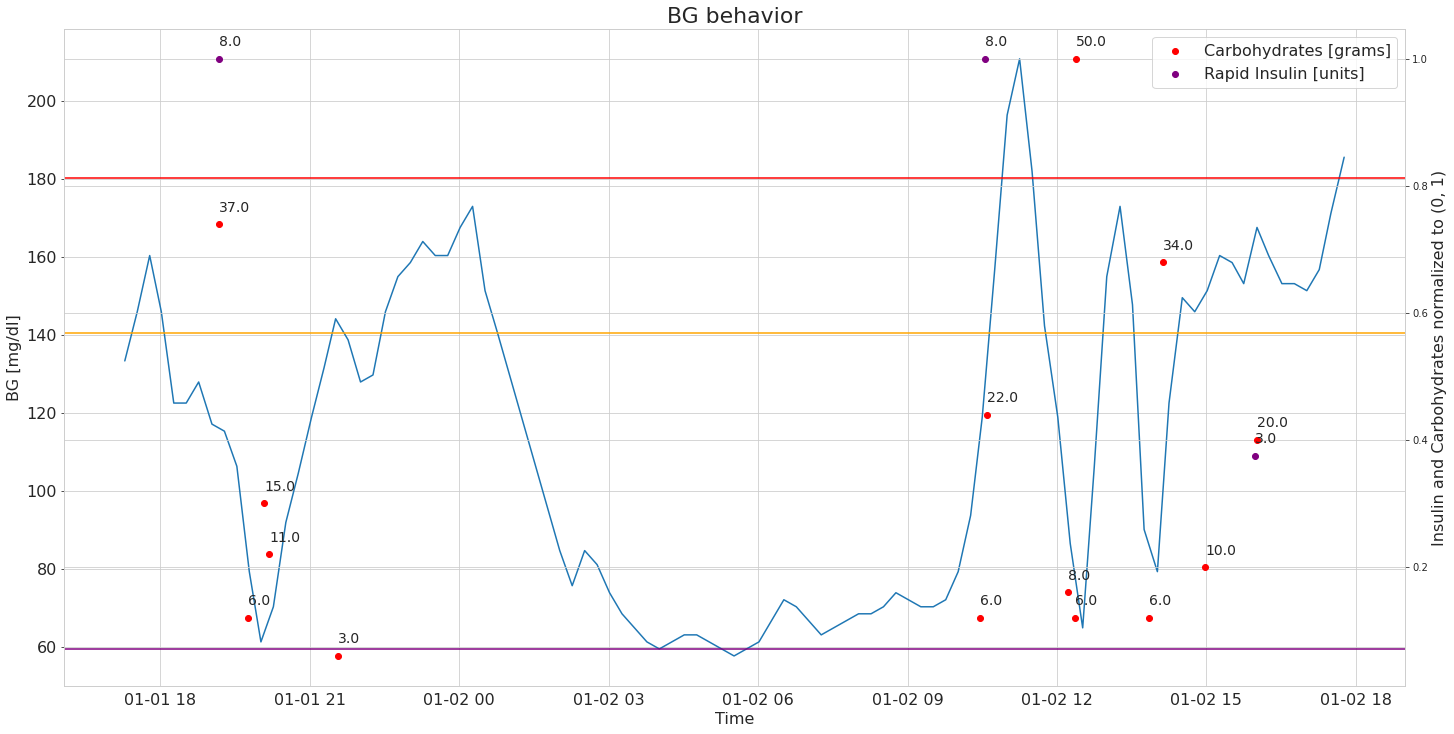

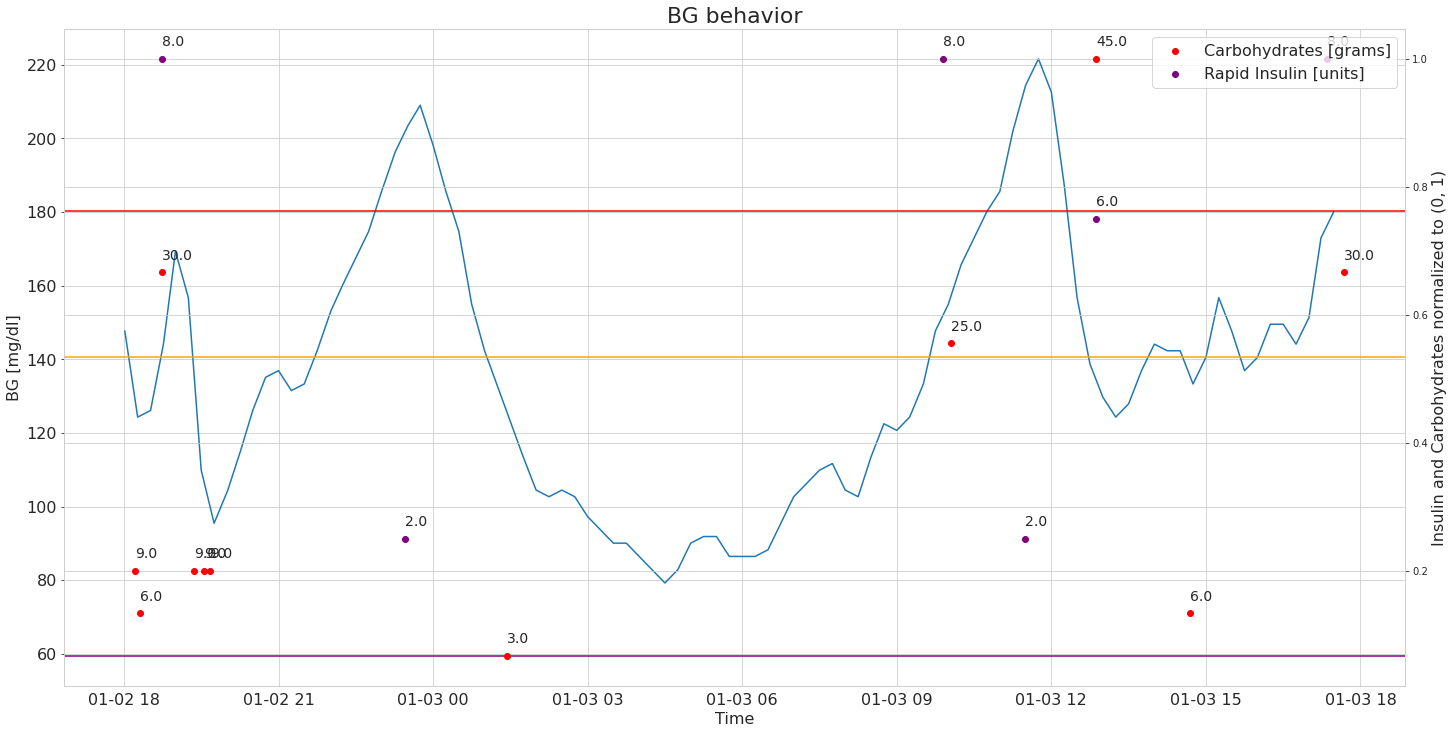

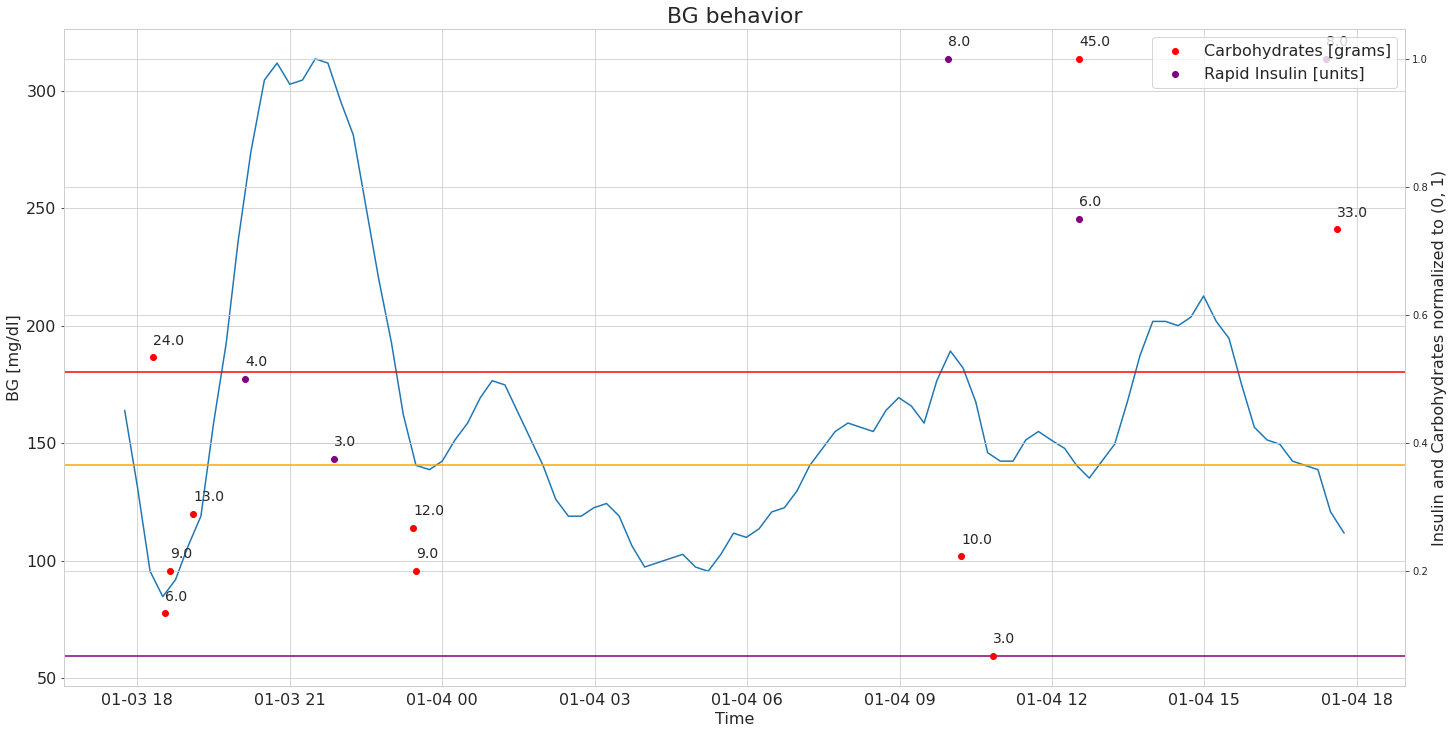

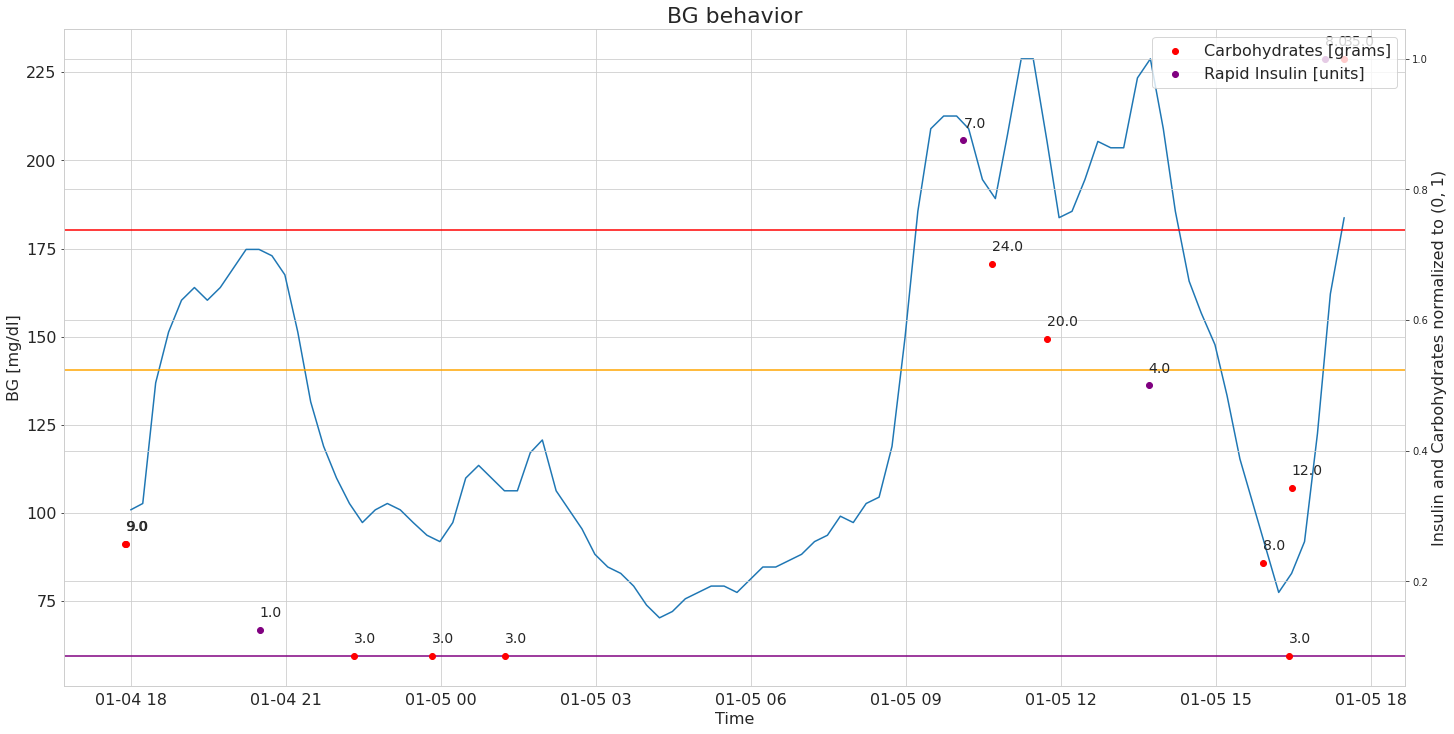

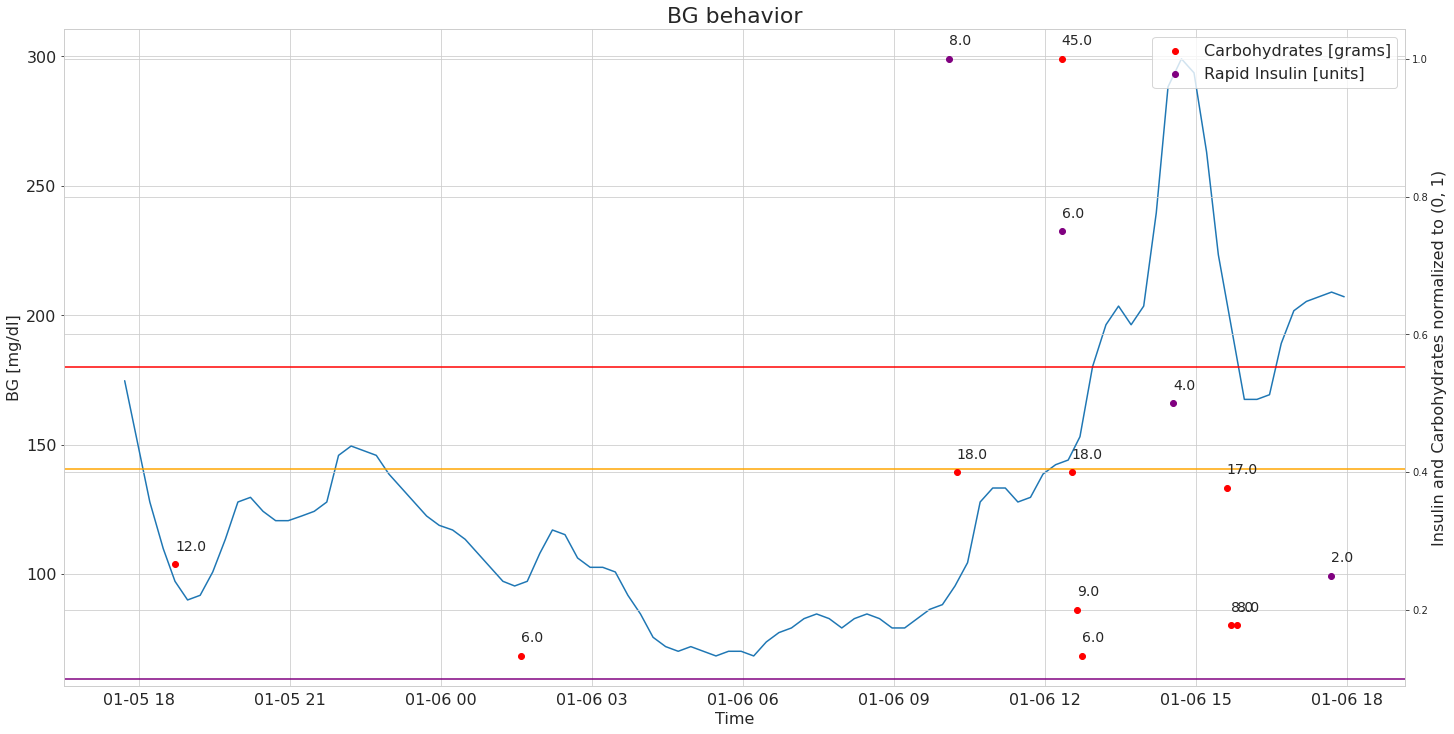

In [177]:
get_daily_charts(df, 30, 5)

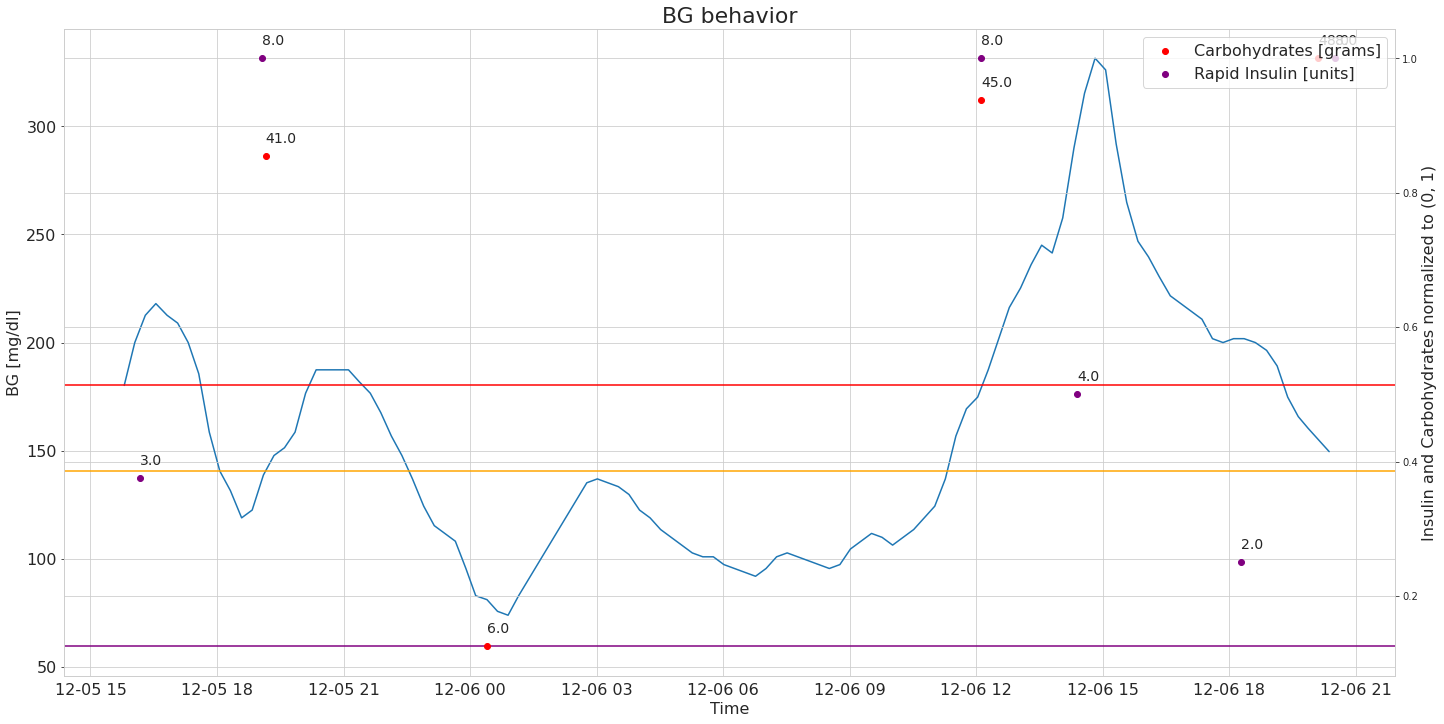

In [215]:
get_daily_charts(df, 4, 1, True)

# Data Analysis

### Find distributions for Glucose change over time with regard to Insulin intake and Carbohydrates consumed

In [8]:
class ColumnTimeFilter:
    def __init__(self, time_start: pd.Timedelta, time_end: pd.Timedelta, column: str):
        self.col = column
        self.time_start = time_start
        self.time_end = time_end

def get_closest_to_time(df: pd.DataFrame, time):
    return df.iloc[np.argmin(np.abs(df["Time"] - time))]

def contains_isolated_data_point(df: pd.DataFrame, time, target_col_filter: ColumnTimeFilter, correlated_col_filter: ColumnTimeFilter=None):
    target_col_time_range = df[(df["Time"] <= time + target_col_filter.time_end) & (df["Time"] >= time - target_col_filter.time_start)]
    if correlated_col_filter:
        cor_col_time_range = df[(df["Time"] <= time + correlated_col_filter.time_end) & (df["Time"] >= time - correlated_col_filter.time_start)]
    # Check if data-point isn't isolated <=> not a single observation of target_col value in the date-range or
    # any observation of correlated_col value in the date-range
    is_isolated = not (target_col_time_range[target_col_filter.col].count() != 1 or
                   (correlated_col_filter and cor_col_time_range[correlated_col_filter.col].count() != 0))
    return is_isolated

def get_isolated_data_points(df: pd.DataFrame, target_col_filter: ColumnTimeFilter, correlated_col_filter: ColumnTimeFilter=None,
                             target_additional_column: str=None):
    results = []
    target_col_data = df.dropna(subset=[target_col_filter.col])
    print(f"Found {len(target_col_data)} data points for {target_col_filter.col}")
    if correlated_col_filter:
        cor_col_data = df.dropna(subset=[correlated_col_filter.col])
        print(f"Found {len(cor_col_data)} data points for correlated column {correlated_col_filter.col}")
    isolated = 0
    glucose_vals = df.dropna(subset=["Glucose"])

    for idx, target_data in target_col_data.iterrows():
        time = target_data["Time"]

        is_isolated = contains_isolated_data_point(df, time, target_col_filter, correlated_col_filter)
        if not is_isolated:
            continue
        else:
            isolated += 1

        observed_col_val_at_start = get_closest_to_time(glucose_vals, time)
        observed_col_val_at_end = get_closest_to_time(glucose_vals, time + target_col_filter.time_end)
        new_row = [
            time,
            target_data[target_col_filter.col],
            observed_col_val_at_start["Glucose"],
            observed_col_val_at_end["Glucose"],
            observed_col_val_at_end["Time"],
            observed_col_val_at_end["Time"] - time,
            observed_col_val_at_end["Glucose"] - observed_col_val_at_start["Glucose"]
        ]
        if target_additional_column:
            new_row.append(target_data[target_additional_column])
        results.append(new_row)

    print(f"Isolated data points from all: {isolated}/{len(target_col_data)}")
    cols = ["Time Start", target_col_filter.col, "Glucose Initial", "Glucose After", "Time End", "Time Range", "Glucose Change"]
    if target_additional_column:
        cols.append(target_additional_column)
    return pd.DataFrame(results, columns=cols)

def get_isolated_behavior(df: pd.DataFrame, target_col_filter: ColumnTimeFilter, correlated_col_filter: ColumnTimeFilter=None):
    time_range_slices = []
    observed_vals = []

    target_col_data = df.dropna(subset=[target_col_filter.col])
    print(f"Found {len(target_col_data)} data points for {target_col_filter.col}")
    if correlated_col_filter:
        cor_col_data = df.dropna(subset=[correlated_col_filter.col])
        print(f"Found {len(cor_col_data)} data points for correlated column {correlated_col_filter.col}")
    isolated = 0
    glucose_vals = df.dropna(subset=["Glucose"])

    for idx, target_data in target_col_data.iterrows():
        time = target_data["Time"]

        is_isolated = contains_isolated_data_point(df, time, target_col_filter, correlated_col_filter)
        if not is_isolated:
            continue

        observed_col_val_at_start = get_closest_to_time(glucose_vals, time)
        observed_col_val_at_end = get_closest_to_time(glucose_vals, time + target_col_filter.time_end)
        # Too big of a gap
        if (observed_col_val_at_end["Time"] - observed_col_val_at_start["Time"]) > target_col_filter.time_end * 1.1:
            continue

        isolated += 1

        relevant_time_range = df[(df["Time"] <= observed_col_val_at_end["Time"]) & (df["Time"] >= observed_col_val_at_start["Time"])].copy()
        relevant_time_range[target_col_filter.col] = target_data[target_col_filter.col]

        time_range_slices.append(relevant_time_range.dropna(subset=["Glucose"]))
        observed_vals.append(target_data[target_col_filter.col])
    print(f"Isolated data points from all: {isolated}/{len(target_col_data)}")
    return time_range_slices, observed_vals

#### Glucose change distribution with regard to Carbohydrates consumed only
Looking at isolated carbohydrate data points - 1.5 hours is roughly what it should take for all the carbohydrates to get into blood after consumption.

Found 1372 data points for Carbohydrates
Isolated data points from all: 295/1372
Found 1372 data points for Carbohydrates
Isolated data points from all: 241/1372
Found 1372 data points for Carbohydrates
Isolated data points from all: 203/1372
Found 1372 data points for Carbohydrates
Isolated data points from all: 165/1372


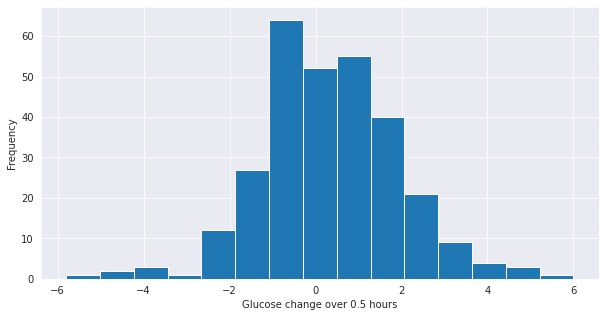

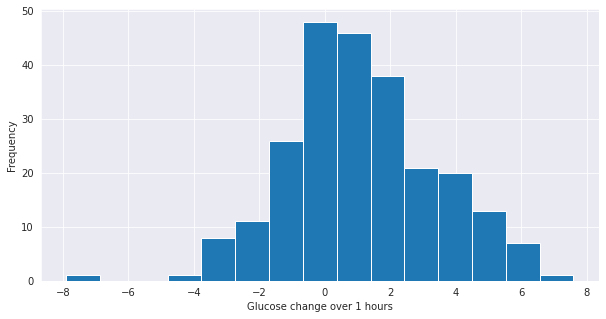

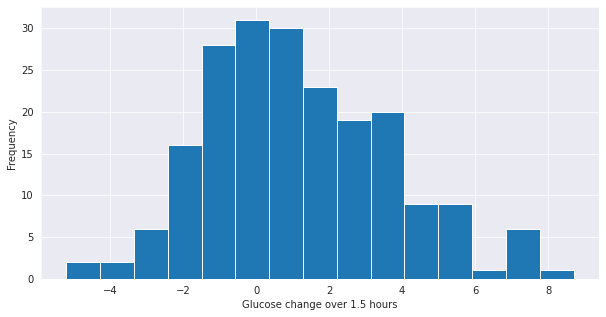

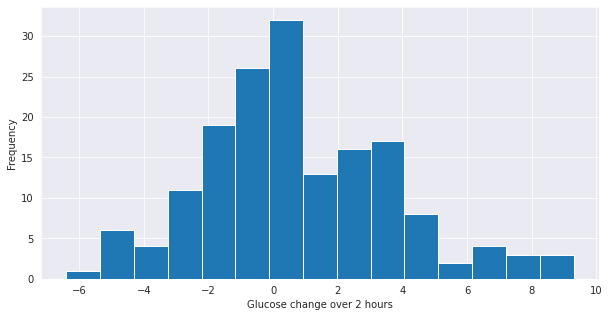

In [24]:
glucose_time_delta_list = [0.5, 1, 1.5, 2]
for time_delta in glucose_time_delta_list:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    carbs_isolated = get_isolated_data_points(df,
                                                ColumnTimeFilter(pd.Timedelta(hours=2), pd.Timedelta(hours=time_delta), "Carbohydrates"))
    ax.hist(carbs_isolated["Glucose Change"], bins=15)
    ax.set_xlabel(f"Glucose change over {time_delta} hours")
    ax.set_ylabel("Frequency")

#### Glucose change distribution with regard to Insulin intake only
Looking at isolated insulin data points - 4 hours is roughly what it should take for most of the rapid insulin effects to wear off.

Found 640 data points for Rapid Insulin
Isolated data points from all: 238/640
Found 640 data points for Rapid Insulin
Isolated data points from all: 229/640
Found 640 data points for Rapid Insulin
Isolated data points from all: 220/640
Found 640 data points for Rapid Insulin
Isolated data points from all: 201/640


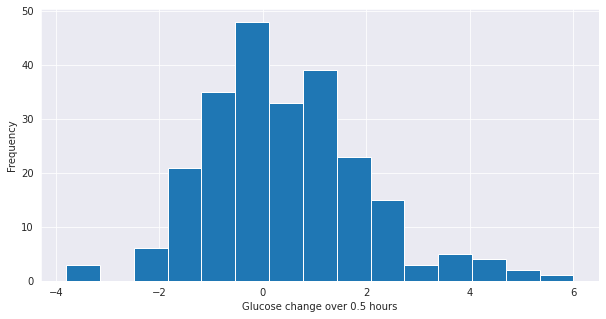

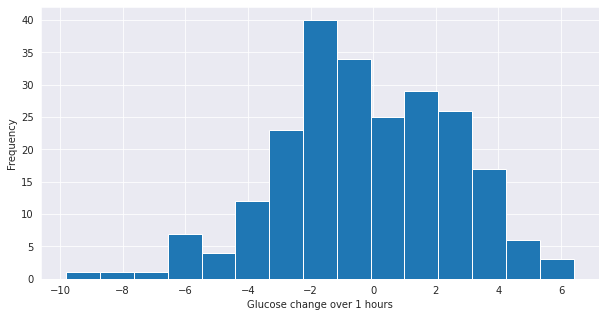

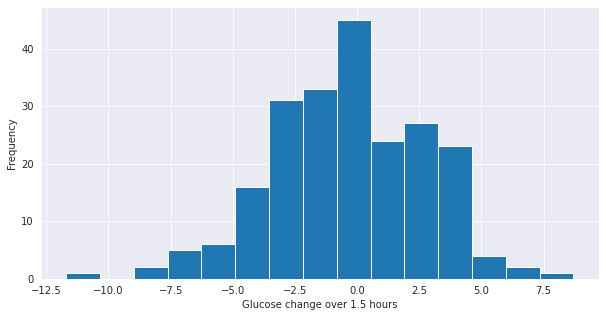

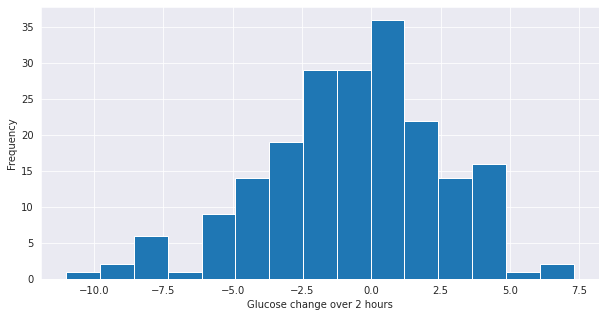

In [25]:
glucose_time_delta_list = [0.5, 1, 1.5, 2]
for time_delta in glucose_time_delta_list:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    insulin_isolated = get_isolated_data_points(df,
                                                ColumnTimeFilter(pd.Timedelta(hours=4), pd.Timedelta(hours=time_delta), "Rapid Insulin"))
    ax.hist(insulin_isolated["Glucose Change"], bins=15)
    ax.set_xlabel(f"Glucose change over {time_delta} hours")
    ax.set_ylabel("Frequency")

#### Glucose change completely isolated

Found 1372 data points for Carbohydrates
Found 640 data points for correlated column Rapid Insulin
Isolated data points from all: 47/1372
Found 640 data points for Rapid Insulin
Found 1372 data points for correlated column Carbohydrates
Isolated data points from all: 60/640
Found 1372 data points for Carbohydrates
Found 640 data points for correlated column Rapid Insulin
Isolated data points from all: 38/1372
Found 640 data points for Rapid Insulin
Found 1372 data points for correlated column Carbohydrates
Isolated data points from all: 33/640


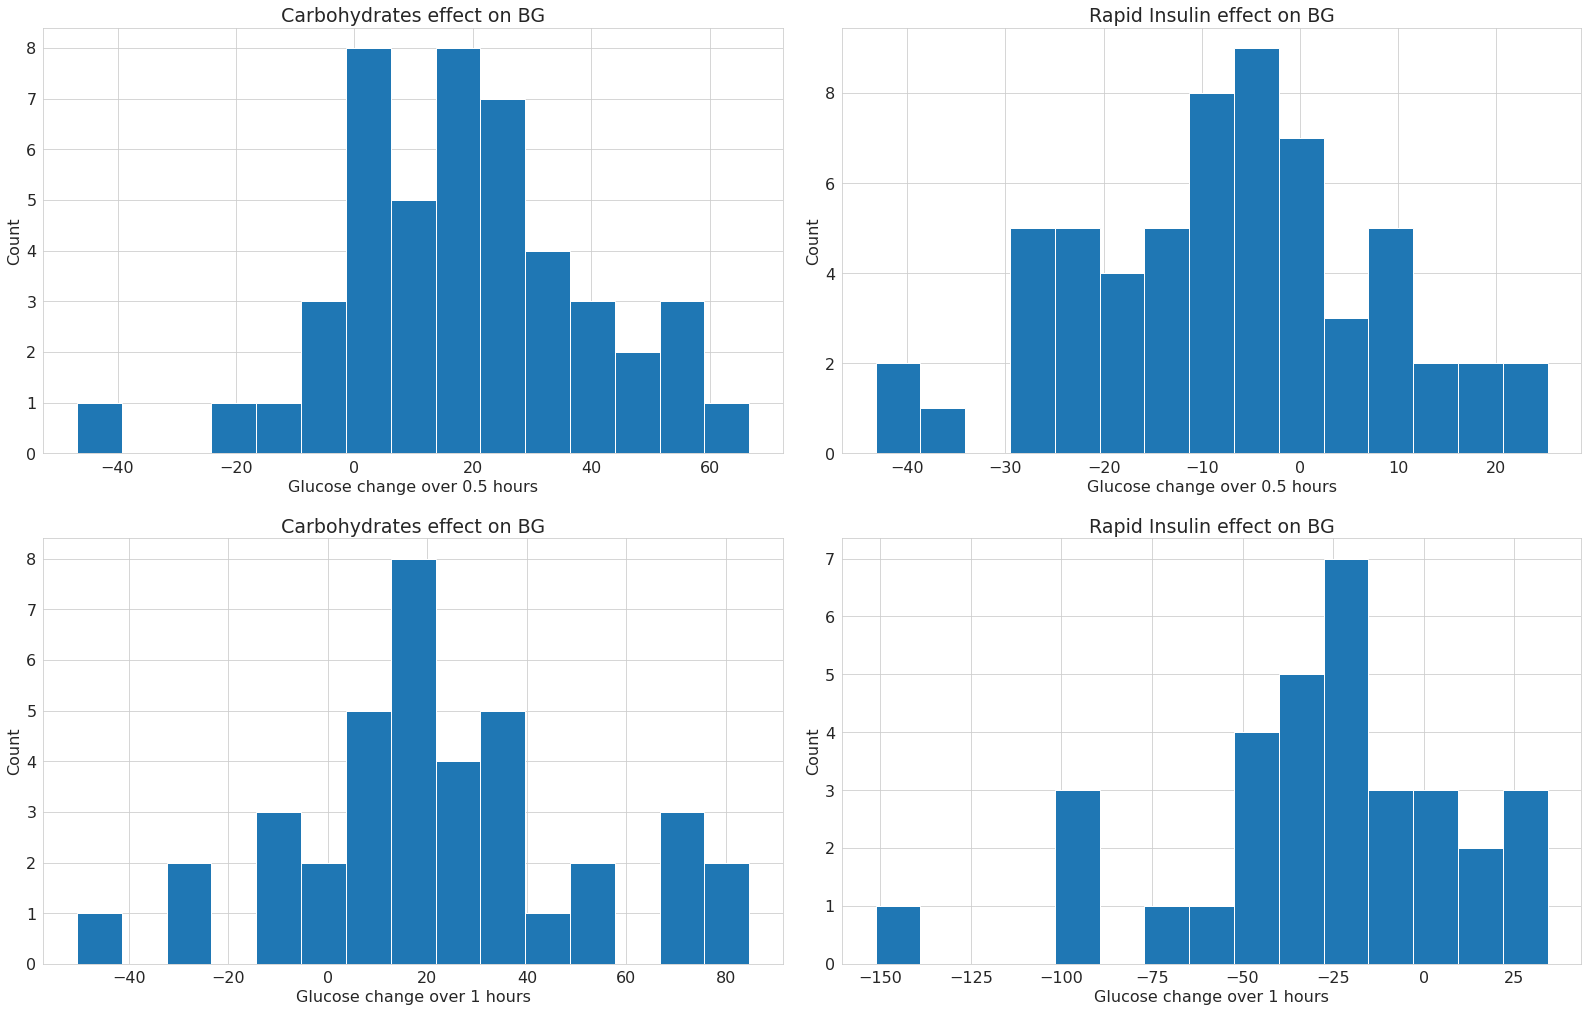

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [229]:
glucose_time_delta_list = [0.5, 1]

label_size, tick_size, title_size = 16, 16, 19
f, axes = plt.subplots(2, 2, figsize=(22,14))

for td_idx, time_delta in enumerate(glucose_time_delta_list):
    for tc_idx, target_col in enumerate(["Carbohydrates", "Rapid Insulin"]):
        fig = plt.figure(figsize=(10, 5))

        if target_col == "Carbohydrates":
            target_filter = ColumnTimeFilter(pd.Timedelta(hours=2), pd.Timedelta(hours=time_delta), "Carbohydrates")
            correlated_filter = ColumnTimeFilter(pd.Timedelta(hours=4), pd.Timedelta(hours=time_delta), "Rapid Insulin")
        else:
            target_filter = ColumnTimeFilter(pd.Timedelta(hours=4), pd.Timedelta(hours=time_delta), "Rapid Insulin")
            correlated_filter = ColumnTimeFilter(pd.Timedelta(hours=2), pd.Timedelta(hours=time_delta), "Carbohydrates")

        insulin_carbs_isolated = get_isolated_data_points(
            df, target_filter, correlated_filter
        )

        axes[td_idx][tc_idx].set_title(f"{target_col} effect on BG", fontsize=title_size)
        axes[td_idx][tc_idx].hist(insulin_carbs_isolated["Glucose Change"], bins=15)
        axes[td_idx][tc_idx].set_xlabel(f"Glucose change over {time_delta} hours", fontsize=label_size)
        axes[td_idx][tc_idx].set_ylabel("Count", fontsize=label_size)
        axes[td_idx][tc_idx].tick_params(axis='both', which='major', labelsize=label_size)
f.tight_layout(pad=0.5)
f.subplots_adjust(hspace=0.2, wspace=0.08)
f.savefig(fname="figures/bg_change_hist.png");

### Glucose behavior trends after Insulin intake

In [30]:
def move_time_series_to_origin(df_to_shift, col: str):
    initial_val = df_to_shift[col].iloc[0]
    initial_time = df_to_shift["Time"].iloc[0]
    df_to_shift[col] -= initial_val

    df_to_shift["Duration"] = df_to_shift["Time"] - initial_time
    df_to_shift["Duration"] = df_to_shift["Duration"].apply(lambda x: x.seconds / 60)
    return df_to_shift

def group_by_time(df_in):
    return df_in.groupby('Time').mean().reset_index()

Found 640 data points for Rapid Insulin
Found 1372 data points for correlated column Carbohydrates
Isolated data points from all: 32/640
[0.0, 1.632699999999998, -5.1232999999999995, -16.270699999999994, -29.332299999999996]


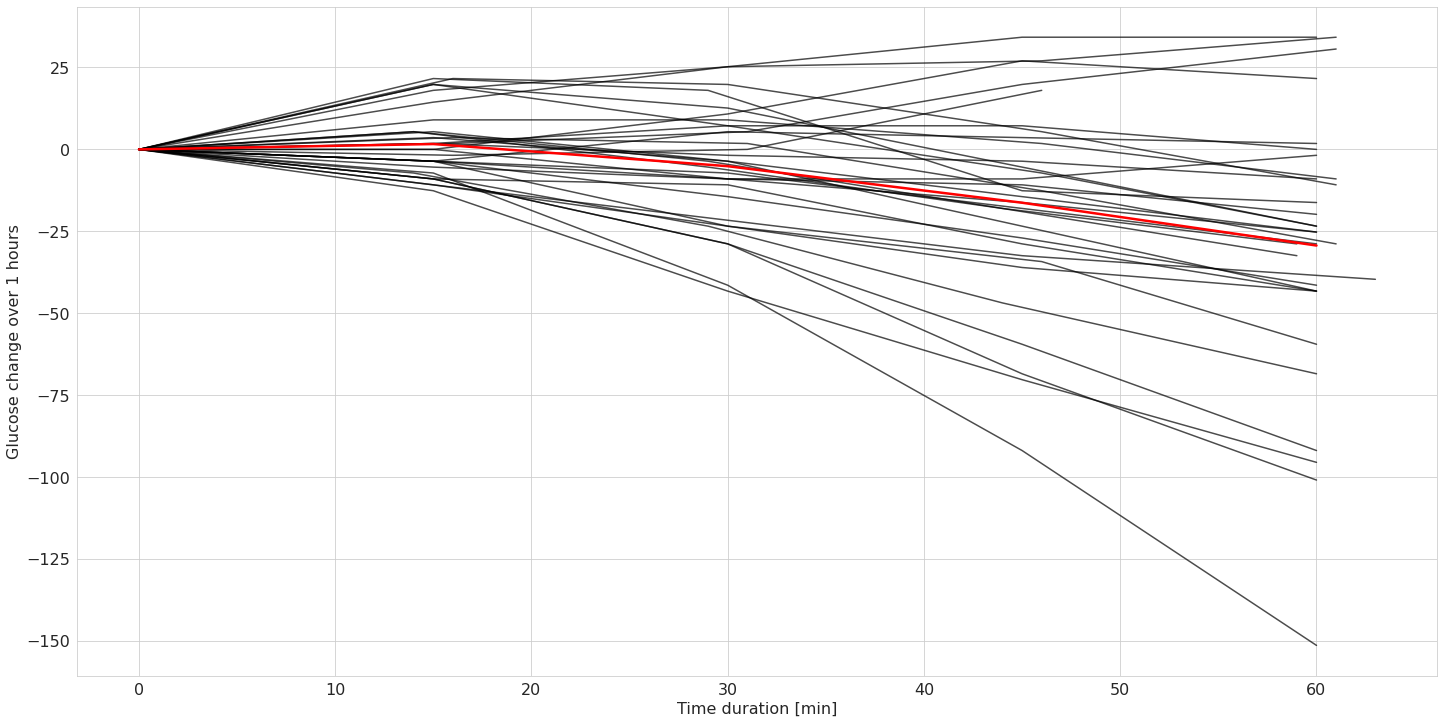

In [44]:
label_size, tick_size, title_size = 16, 16, 19
f, ax = plt.subplots(1, 1, figsize=(20,10))

for td_idx, time_delta in enumerate([1]):
    time_range_slices, observed_target_vals = get_isolated_behavior(
        df,
        ColumnTimeFilter(pd.Timedelta(hours=4), pd.Timedelta(hours=time_delta), "Rapid Insulin"),
        ColumnTimeFilter(pd.Timedelta(hours=2), pd.Timedelta(hours=time_delta), "Carbohydrates")
    )

    # Min max normalize
    min_val, max_val = min(observed_target_vals), max(observed_target_vals)
    observed_target_vals = [(x - min_val) / (max_val - min_val) for x in observed_target_vals]

    max_len = max([len(slc) for slc in time_range_slices])
    means = [0 for _ in range(max_len)]
    time_for_means = [i*15 for i in range(max_len)]

    for idx, time_range in enumerate(time_range_slices):
        time_range.reset_index(inplace=True)
        time_range.sort_values(by='Time', inplace=True)
        time_range = move_time_series_to_origin(group_by_time(time_range), "Glucose")

        for i in range(min(len(means), len(time_range))):
            means[i] += time_range["Glucose"].iloc[i]

        observed_val = observed_target_vals[idx]

        ax.plot(time_range["Duration"], time_range["Glucose"], color='black', alpha=0.7)
        ax.set_xlabel("Time duration [min]", fontsize=label_size)
        ax.set_ylabel(f"Glucose change over {time_delta} hours", fontsize=label_size)
        ax.tick_params(axis='both', which='major', labelsize=label_size)

    means = [x / len(time_range_slices) for x in means]
    print(means)
    ax.plot(time_for_means, means, color='red', linewidth=2.5)
f.tight_layout(pad=0.5)
f.savefig(fname="figures/bg_change_post_insulin_trends.png");

Found 1372 data points for Carbohydrates
Found 640 data points for correlated column Rapid Insulin
Isolated data points from all: 37/1372
[0.0, 4.7718054054054075, 17.57777297297297, 24.151178378378376, 22.787805405405404]


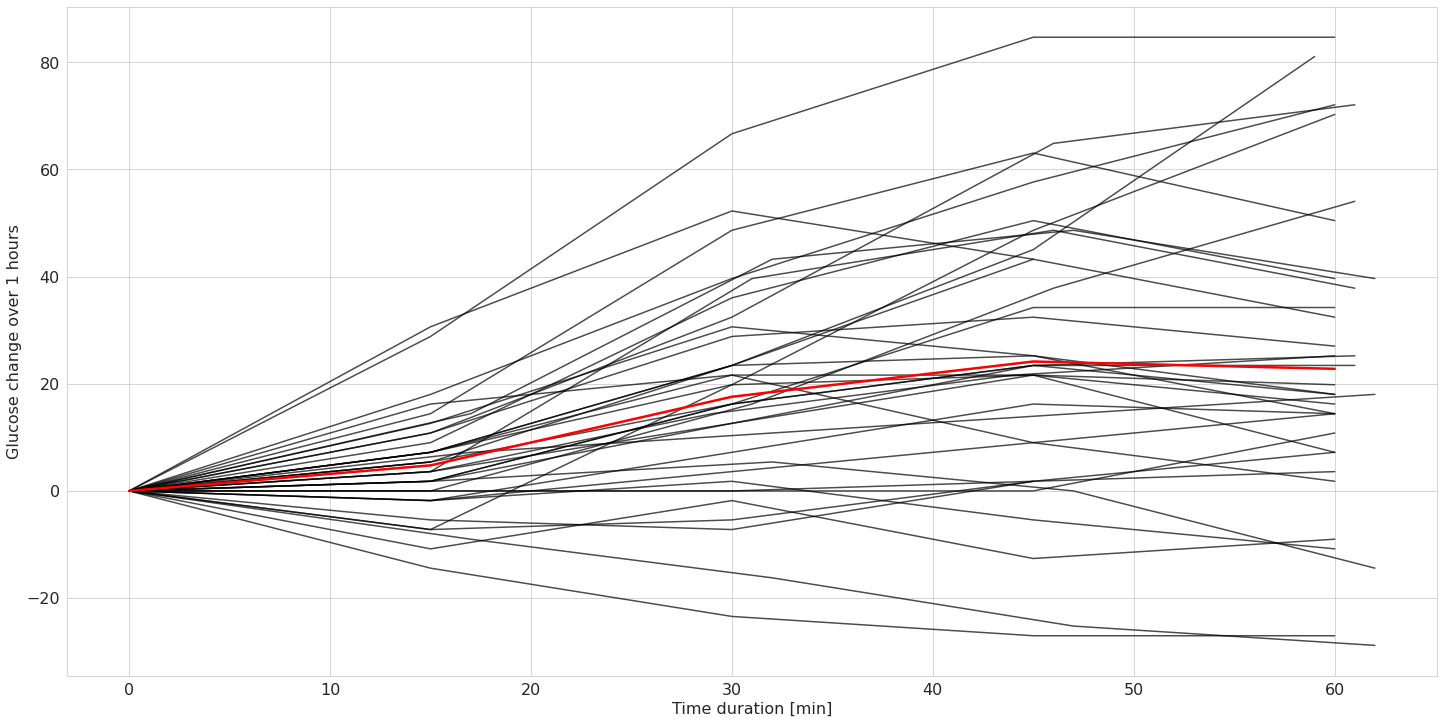

In [43]:
label_size, tick_size, title_size = 16, 16, 19
f, ax = plt.subplots(1, 1, figsize=(20,10))

for time_delta in [1]:
    time_range_slices, observed_target_vals = get_isolated_behavior(
        df,
        ColumnTimeFilter(pd.Timedelta(hours=2), pd.Timedelta(hours=time_delta), "Carbohydrates"),
        ColumnTimeFilter(pd.Timedelta(hours=4), pd.Timedelta(hours=time_delta), "Rapid Insulin")
    )

    # Min max normalize
    min_val, max_val = min(observed_target_vals), max(observed_target_vals)
    observed_target_vals = [(x - min_val) / (max_val - min_val) for x in observed_target_vals]

    max_len = max([len(slc) for slc in time_range_slices])
    means = [0 for _ in range(max_len)]
    time_for_means = [i*15 for i in range(max_len)]

    for idx, time_range in enumerate(time_range_slices):
        observed_val = observed_target_vals[idx]
        time_range.reset_index(inplace=True)
        time_range.sort_values(by='Time', inplace=True)
        time_range = move_time_series_to_origin(group_by_time(time_range), "Glucose")

        for i in range(min(len(means), len(time_range))):
            means[i] += time_range["Glucose"].iloc[i]

        #ax.plot(time_range["Duration"], time_range["Glucose"], color='black', alpha=min(0.2 + observed_val, 1))
        ax.plot(time_range["Duration"], time_range["Glucose"], color='black', alpha=0.7)
        ax.set_xlabel("Time duration [min]", fontsize=label_size)
        ax.set_ylabel(f"Glucose change over {time_delta} hours", fontsize=label_size)
        ax.tick_params(axis='both', which='major', labelsize=label_size)

    means = [x / len(time_range_slices) for x in means]
    print(means)
    ax.plot(time_for_means, means, color='red', linewidth=2.5)
f.tight_layout(pad=0.5)
f.savefig(fname="figures/bg_change_post_carbohydrates_trends.png");

### Analysis of Insulin - Glucose change and Carbohydrates - Glucose change relations

Found 1372 data points for Carbohydrates
Found 640 data points for correlated column Rapid Insulin
Isolated data points from all: 47/1372
Found 1372 data points for Carbohydrates
Found 640 data points for correlated column Rapid Insulin
Isolated data points from all: 38/1372


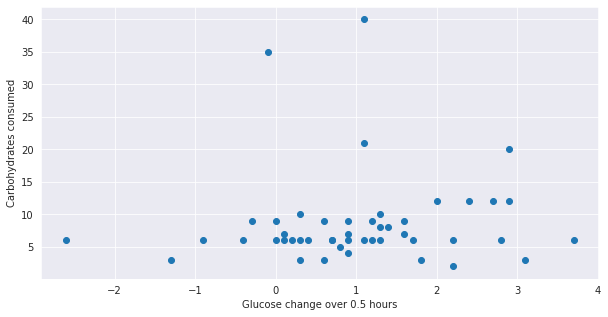

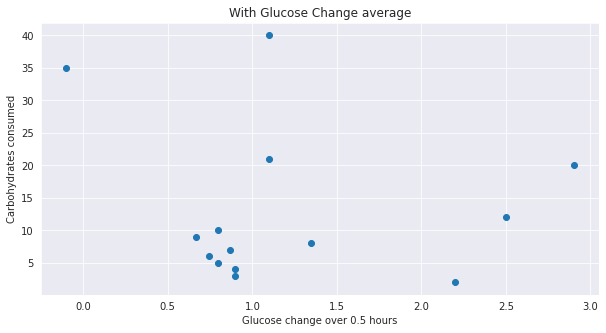

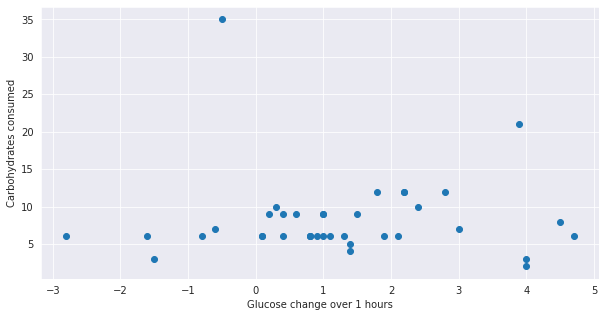

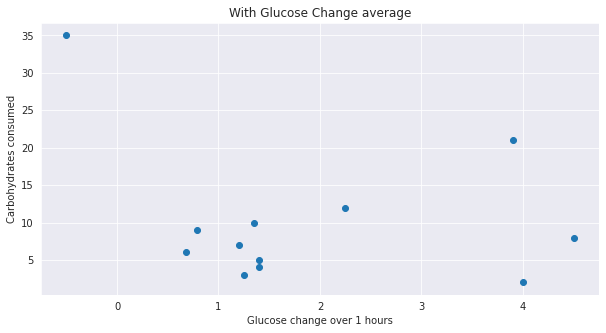

In [107]:
glucose_time_delta_list = [0.5, 1]
for time_delta in glucose_time_delta_list:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    insulin_carbs_isolated = get_isolated_data_points(
        df,
        ColumnTimeFilter(pd.Timedelta(hours=2), pd.Timedelta(hours=time_delta), "Carbohydrates"),
        ColumnTimeFilter(pd.Timedelta(hours=4), pd.Timedelta(hours=time_delta), "Rapid Insulin"))
    ax.scatter(insulin_carbs_isolated["Glucose Change"], insulin_carbs_isolated["Carbohydrates"])
    ax.set_ylabel("Carbohydrates consumed")
    ax.set_xlabel(f"Glucose change over {time_delta} hours")

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    insulin_carbs_isolated = insulin_carbs_isolated.groupby("Carbohydrates").mean().reset_index()
    ax.scatter(insulin_carbs_isolated["Glucose Change"], insulin_carbs_isolated["Carbohydrates"])
    ax.set_ylabel("Carbohydrates consumed")
    ax.set_xlabel(f"Glucose change over {time_delta} hours")
    ax.set_title("With Glucose Change average")

Found 640 data points for Rapid Insulin
Found 1372 data points for correlated column Carbohydrates
Isolated data points from all: 60/640
Found 640 data points for Rapid Insulin
Found 1372 data points for correlated column Carbohydrates
Isolated data points from all: 33/640


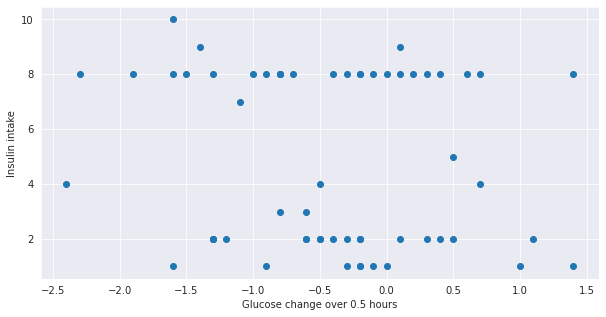

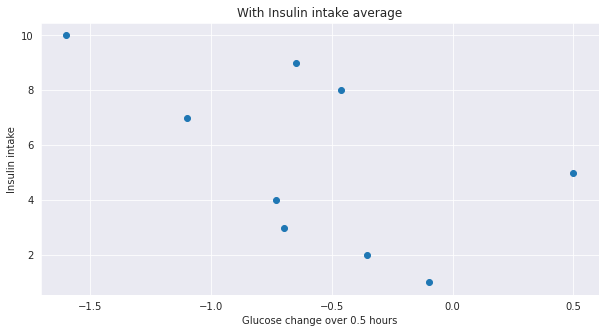

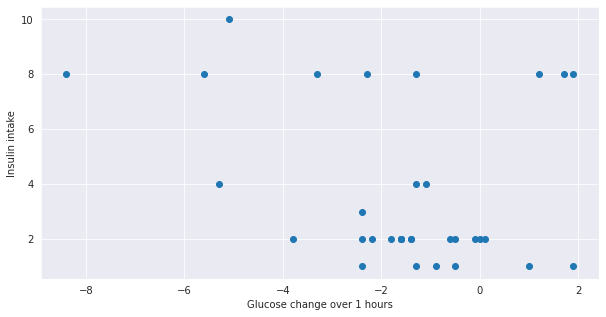

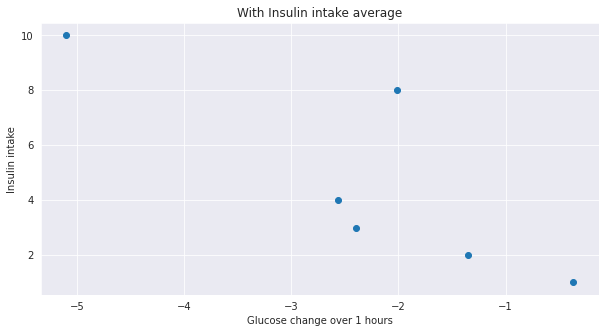

In [108]:
glucose_time_delta_list = [0.5, 1]
for time_delta in glucose_time_delta_list:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    insulin_carbs_isolated = get_isolated_data_points(
        df,
        ColumnTimeFilter(pd.Timedelta(hours=4), pd.Timedelta(hours=time_delta), "Rapid Insulin"),
        ColumnTimeFilter(pd.Timedelta(hours=2), pd.Timedelta(hours=time_delta), "Carbohydrates"))
    ax.scatter(insulin_carbs_isolated["Glucose Change"], insulin_carbs_isolated["Rapid Insulin"])
    ax.set_ylabel("Insulin intake")
    ax.set_xlabel(f"Glucose change over {time_delta} hours")

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    insulin_carbs_isolated = insulin_carbs_isolated.groupby("Rapid Insulin").mean().reset_index()
    ax.scatter(insulin_carbs_isolated["Glucose Change"], insulin_carbs_isolated["Rapid Insulin"])
    ax.set_ylabel("Insulin intake")
    ax.set_xlabel(f"Glucose change over {time_delta} hours")
    ax.set_title("With Insulin intake average")

### Correlation of food glycemic index, amount of carbohydrates consumed and glucose change

In [11]:
# Removing redundant spaces around the values (miss-clicks when inputting the data)
df["GI"] = df["GI"].str.strip()
print(df["GI"].unique())

[nan 'Medium' 'Very High' 'Low' 'High' '1' '2' '3']


We can see there are multiple values in GI, the one which interests us are the string values: **Low, Medium, High and Very High**, which are labels for estimates of the food glycemic index. The higher the glycemic index, the faster should glucose be released when digested.

In [12]:
GI_valus = ["Low", "Medium", "High", "Very High"]
df["GI"] = df.apply(lambda row: row["GI"] if row["GI"] in GI_valus else np.nan, axis=1)

# Encode as ordinal features
enc = {
    "Low": 0,
    "Medium": 1,
    "High": 2,
    "Very High": 3
}
df["GI"] = df["GI"].map(enc)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20481 entries, 28189 to 47203
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Time                    20481 non-null  datetime64[ns]
 1   Record Type             19015 non-null  float64       
 2   Glucose                 11970 non-null  float64       
 3   Scan Glucose (mmol/L)   6359 non-null   float64       
 4   Rapid Insulin           640 non-null    float64       
 5   Carbohydrates           1372 non-null   float64       
 6   Long Insulin            126 non-null    float64       
 7   Strip Glucose (mmol/L)  45 non-null     float64       
 8   Previous Time           4 non-null      object        
 9   Updated Time            4 non-null      object        
 10  Date                    1466 non-null   object        
 11  Tags                    5 non-null      object        
 12  Insulin (Meal)          235 non-null    fl

Found 1003 data points for Carbohydrates
Found 446 data points for correlated column Rapid Insulin
Isolated data points from all: 43/1003
Found 1003 data points for Carbohydrates
Found 446 data points for correlated column Rapid Insulin
Isolated data points from all: 34/1003
Found 1003 data points for Carbohydrates
Found 446 data points for correlated column Rapid Insulin
Isolated data points from all: 30/1003
Found 1003 data points for Carbohydrates
Found 446 data points for correlated column Rapid Insulin
Isolated data points from all: 28/1003


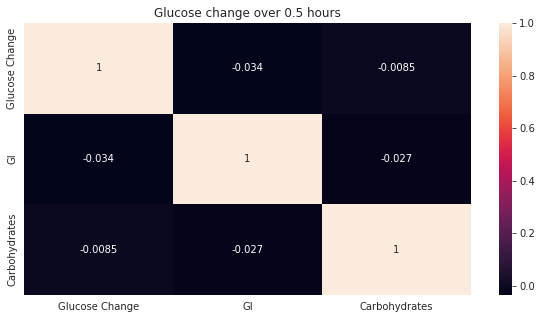

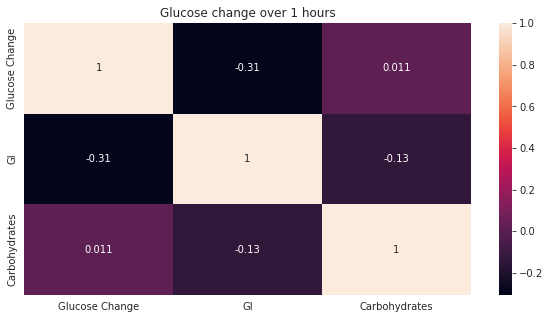

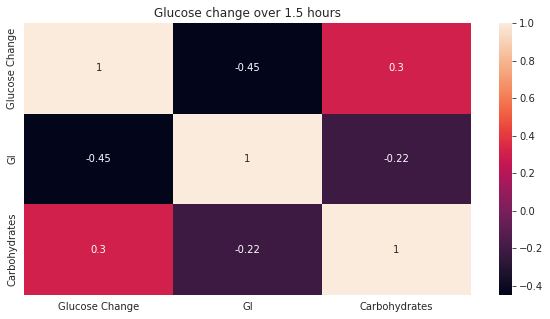

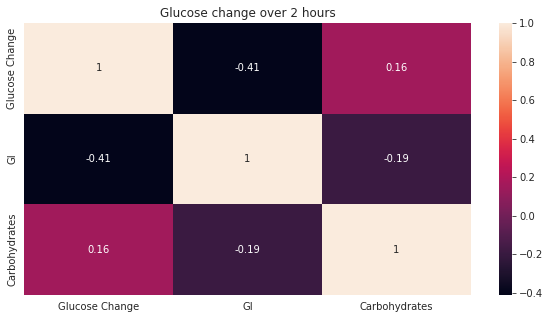

In [114]:
glucose_time_delta_list = [0.5, 1, 1.5, 2]
for time_delta in glucose_time_delta_list:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()
    insulin_carbs_isolated = get_isolated_data_points(
        df[df["Time"] >= mysugr_start_date],
        ColumnTimeFilter(pd.Timedelta(hours=1.5), pd.Timedelta(hours=time_delta), "Carbohydrates"),
        ColumnTimeFilter(pd.Timedelta(hours=4), pd.Timedelta(hours=time_delta), "Rapid Insulin"),
        "GI"
    )
    #print(insulin_carbs_isolated[["Glucose Change", "GI", "Carbohydrates"]].dropna().head(20))
    sns.heatmap(insulin_carbs_isolated[["Glucose Change", "GI", "Carbohydrates"]]
                .corr(method="pearson"), annot=True, ax=ax)
    ax.set_title(f"Glucose change over {time_delta} hours")

## Correlations

In [124]:
glucose_cor = df.copy()
sample_rate = 15
glucose_cor = glucose_cor.set_index('Time').resample(f'{sample_rate}T').agg({
    'Glucose': pd.Series.mean,
    'Rapid Insulin': pd.Series.sum,
    'Carbohydrates': pd.Series.sum
}).reset_index()

# Interpolate
glucose_cor["Glucose"] = glucose_cor["Glucose"].interpolate(method="linear")

roll_window_width = 4 * 60 // sample_rate
glucose_cor['Rapid Insulin 4h'] = glucose_cor['Rapid Insulin'].rolling(roll_window_width).sum()
glucose_cor['Rapid Insulin 4h'].replace(to_replace=np.nan, method='bfill', inplace=True)

roll_window_width = 2 * 60 // sample_rate
glucose_cor['Carbohydrates 2h'] = glucose_cor['Carbohydrates'].rolling(roll_window_width).sum()
glucose_cor['Carbohydrates 2h'].replace(to_replace=np.nan, method='bfill', inplace=True)

<AxesSubplot:>

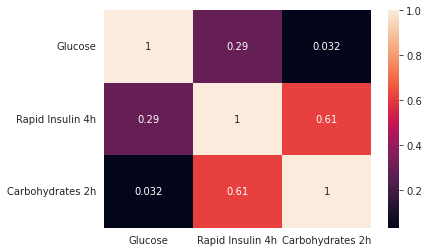

In [125]:
sns.heatmap(glucose_cor[["Glucose", "Rapid Insulin 4h", "Carbohydrates 2h"]]
            .corr(method="pearson"), annot=True)

## Physical activity influence

In [253]:
fitbit_df = load_fitbit_dataset()

In [254]:
fitbit_df

,Time,bpm,distance,calories
0,2021-11-28 00:00:00,NaN,0.0,1.08
1,2021-11-28 00:01:00,NaN,0.0,1.08
2,2021-11-28 00:02:00,NaN,0.0,1.08
3,2021-11-28 00:03:00,NaN,0.0,1.08
4,2021-11-28 00:04:00,NaN,0.0,1.08
...,...,...,...,...
214382,2022-04-25 21:02:00,NaN,0.0,1.18
214383,2022-04-25 21:03:00,NaN,0.0,1.18
214384,2022-04-25 21:04:00,NaN,0.0,1.18
214385,2022-04-25 21:05:00,NaN,0.0,1.18


In [256]:
fitbit_df

,Time,bpm,distance,calories
0,2021-11-28 00:00:00,NaN,0.0,1.08
1,2021-11-28 00:01:00,NaN,0.0,1.08
2,2021-11-28 00:02:00,NaN,0.0,1.08
3,2021-11-28 00:03:00,NaN,0.0,1.08
4,2021-11-28 00:04:00,NaN,0.0,1.08
...,...,...,...,...
214382,2022-04-25 21:02:00,NaN,0.0,1.18
214383,2022-04-25 21:03:00,NaN,0.0,1.18
214384,2022-04-25 21:04:00,NaN,0.0,1.18
214385,2022-04-25 21:05:00,NaN,0.0,1.18


In [258]:
def get_physical():
    df_physical = pd.concat([df, fitbit_df], ignore_index=True)
    df_physical = df_physical[(df_physical["Time"] >= start_date) & (df_physical["Time"] <= end_date)]
    sample_rate = 15
    df_physical = df_physical.set_index('Time').resample(f'{sample_rate}T').agg({
        'Glucose': pd.Series.mean,
        'calories': pd.Series.sum,
        'distance': pd.Series.sum,
        'bpm': pd.Series.mean,
    }).reset_index()
    df_physical["Glucose"] = df_physical["Glucose"].interpolate(method="linear")
    df_physical["bpm"] = df_physical["bpm"].interpolate(method="linear")
    return df_physical

In [259]:
df_physical = get_physical()
df_physical

,Time,Glucose,calories,distance,bpm
0,2021-12-01 00:00:00,131.5168,19.59,22.9,60.312381
1,2021-12-01 00:15:00,144.1280,17.96,73.5,63.833466
2,2021-12-01 00:30:00,154.9376,17.86,5.5,51.559524
3,2021-12-01 00:45:00,158.5408,17.62,0.0,54.447937
4,2021-12-01 01:00:00,163.9456,21.17,0.0,51.072959
...,...,...,...,...,...
12284,2022-04-07 23:00:00,154.9376,56.75,40.1,72.603725
12285,2022-04-07 23:15:00,154.9376,52.45,17.2,70.983362
12286,2022-04-07 23:30:00,151.3344,60.42,155.5,78.193862
12287,2022-04-07 23:45:00,160.3424,60.95,255.4,84.487015


In [261]:
df_physical[["calories", "distance", "bpm"]].describe()

,calories,distance,bpm
count,12289.000000,12289.000000,12289.000000
mean,26.491034,65.373106,71.068514
std,15.760745,148.617408,13.238876
min,6.460000,0.000000,47.022222
25%,16.400000,0.000000,60.309206
50%,19.940000,4.800000,69.534639
75%,29.610000,54.800000,78.844048
max,135.290000,1151.100000,142.866970


In [264]:
df_physical = get_physical()
sample_rate = 15
history = 3
roll_window_width = history * 60 // sample_rate

df_physical[f'calories {history}h'] = df_physical['calories'].rolling(roll_window_width).sum()
df_physical[f'calories {history}h'].replace(to_replace=np.nan, method='bfill', inplace=True)
df_physical[f'distance {history}h'] = df_physical['distance'].rolling(roll_window_width).sum()
df_physical[f'distance {history}h'].replace(to_replace=np.nan, method='bfill', inplace=True)
df_physical[f'bpm {history}h'] = df_physical['bpm'].rolling(roll_window_width).mean()

corr_3h = df_physical[["Glucose", f"calories {history}h", f"distance {history}h", f"bpm {history}h"]].corr(method="pearson")

In [265]:
history = 1
roll_window_width = history * 60 // sample_rate
df_physical[f'calories {history}h'] = df_physical['calories'].rolling(roll_window_width).sum()
df_physical[f'calories {history}h'].replace(to_replace=np.nan, method='bfill', inplace=True)
df_physical[f'distance {history}h'] = df_physical['distance'].rolling(roll_window_width).sum()
df_physical[f'distance {history}h'].replace(to_replace=np.nan, method='bfill', inplace=True)
df_physical[f'bpm {history}h'] = df_physical['bpm'].rolling(roll_window_width).mean()

corr_1h = df_physical[["Glucose", f"calories {history}h", f"distance {history}h", f"bpm {history}h"]].corr(method="pearson")

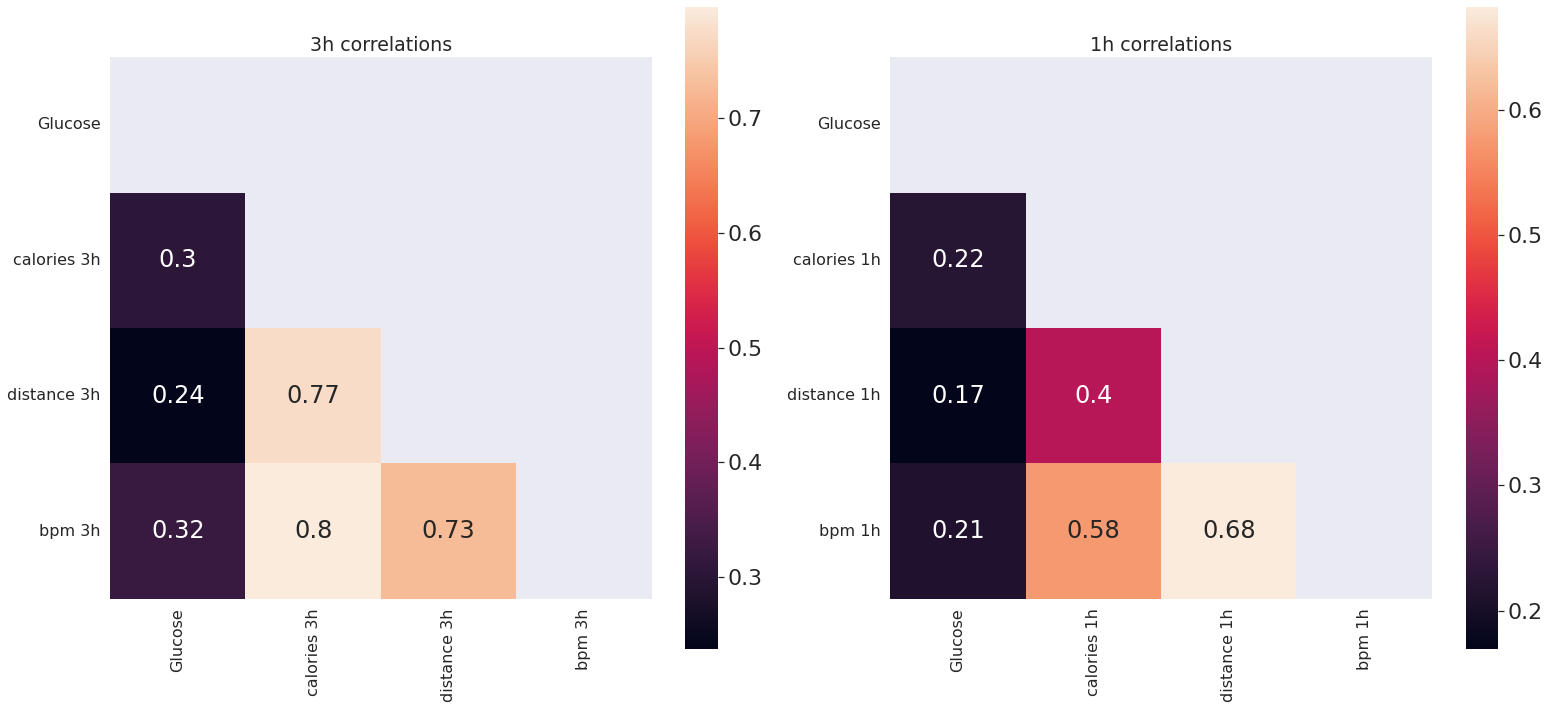

In [280]:
f, axes = plt.subplots(1, 2, figsize=(22,10))
label_size, tick_size, title_size = 16, 16, 19

sns.set(font_scale=2)
for idx, duration in enumerate([3, 1]):
    if duration == 1:
        mask = np.zeros_like(corr_1h)
        corr = corr_1h
    elif duration == 3:
        mask = np.zeros_like(corr_3h)
        corr = corr_3h
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        sns.heatmap(corr, mask=mask, square=True, annot=True, ax=axes[idx])
        axes[idx].set_title(f"{duration}h correlations", fontsize=title_size)
        #axes[idx].set_xlabel(fontsize=label_size)
        #axes[idx].set_ylabel(fontsize=label_size)
        axes[idx].tick_params(axis='both', which='major', labelsize=label_size)
f.tight_layout(pad=0.5)
f.savefig(fname="figures/bg_physical_correlations.png");

In [78]:
def get_change(window):
    w = np.array(window)
    return w[len(w) - 1] - w[0]

df_physical = get_physical()
history = 1
roll_window_width = int(history * 60 // sample_rate)
gluc_history = 0.5
gluc_roll_window_width = int(gluc_history * 60 // sample_rate)

df_physical[f'Glucose Change {gluc_history}h'] = df_physical['Glucose'].rolling(gluc_roll_window_width).apply(func=get_change)
df_physical[f'calories {history}h'] = df_physical['calories'].rolling(roll_window_width).sum()
df_physical[f'calories {history}h'].replace(to_replace=np.nan, method='bfill', inplace=True)
df_physical[f'distance {history}h'] = df_physical['distance'].rolling(roll_window_width).sum()
df_physical[f'distance {history}h'].replace(to_replace=np.nan, method='bfill', inplace=True)
df_physical[f'bpm {history}h'] = df_physical['bpm'].rolling(roll_window_width).mean()

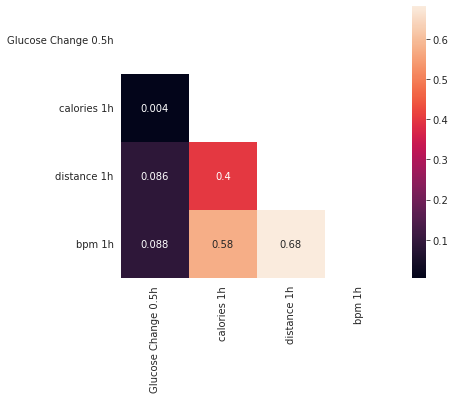

In [79]:
corr = df_physical[[f"Glucose Change {gluc_history}h", f"calories {history}h", f"distance {history}h", f"bpm {history}h"]].corr(method="pearson")

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(corr, mask=mask, square=True, annot=True)

In [312]:
sns.set_style("whitegrid")

## Glucose periodicity

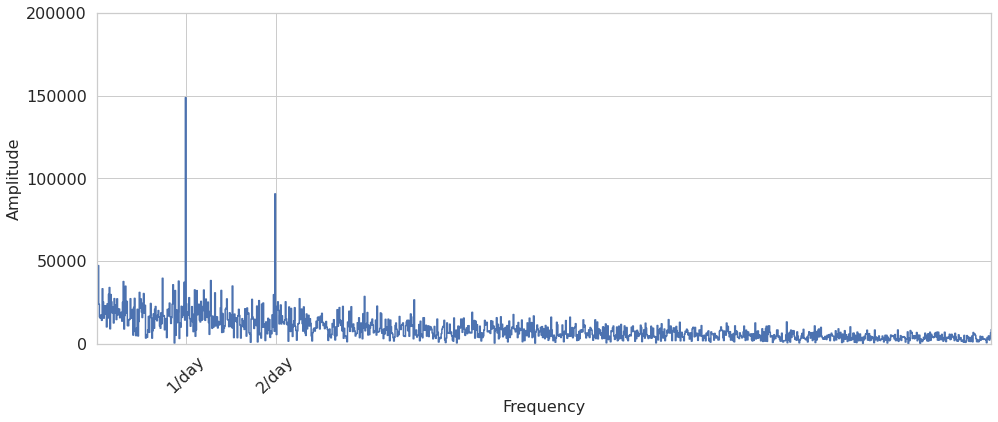

In [314]:
import tensorflow as tf

glucose_fft = df.copy()
#glucose_fft["Glucose"] = glucose_fft["Glucose"] / 18.016
glucose_fft = glucose_fft.dropna(subset=['Glucose'], how='all')
glucose_fft = glucose_fft.set_index('Time').resample('15T').agg({'Glucose':pd.Series.mean}).reset_index()

# Interpolate
glucose_fft["Glucose"] = glucose_fft["Glucose"].interpolate(method="linear")

fft = tf.signal.rfft(glucose_fft['Glucose'])
f_per_dataset = np.arange(0, len(fft))

n_samples_15_min = len(glucose_fft['Glucose'])
minute_15_per_day = 24 * 4
days_per_dataset = n_samples_15_min / minute_15_per_day

f_per_day = f_per_dataset / days_per_dataset

label_size, tick_size, title_size = 16, 16, 19
f, ax = plt.subplots(1, 1, figsize=(14,6))
ax.step(f_per_day, np.abs(fft))
ax.set_ylim(0, 200000)
ax.set_xlim([0, 10])

#ax.set_title("BG Fast Fourier transform", fontsize=title_size)
ax.set_xlabel("Frequency", fontsize=label_size)
ax.set_ylabel("Amplitude", fontsize=label_size)

plt.xticks([1, 2], labels=['1/day', '2/day'], fontsize=tick_size, rotation=45)
plt.yticks(fontsize=tick_size)
f.tight_layout(pad=0.5)
f.savefig(fname="figures/bg_fft.png");